# Imported Libraries

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

# reload utils to get the latest version of the functions
import importlib
import os
os.chdir(r"C:\Users\AlisyaMustikaa\Documents\GitHub\BESS_Revenue_Scenarios")
import utils


import utils

importlib.reload(utils)

<module 'utils' from 'C:\\Users\\AlisyaMustikaa\\Documents\\GitHub\\BESS_Revenue_Scenarios\\utils.py'>

# BESS Revenue Scenarios
- This Notebook implements a simple linear model together with scenario forecasting in order to generate future scenarios for the evolutoin of BESS Revenues.
We estimate battery capacity in the Netherlands using sparse available data, namely: 
    - CBS Table on electricity storage for historical data ()
    - Netbeheer Nederland's Scenario's investeringsplannen for future scenario data ()
        - Then we make two interpolations, a linear one and a logistic one, which results in 6 scenarios of battery capacities.
- We adjust the revenues for inflation using the Dutch HCPI from CBS (https://opendata.cbs.nl/#/CBS/en/dataset/83133ENG/table)
- We get Natural Gas Prices from Yahoo Finance API ()
- We get Renewable energy production [Solar, Wind Onshore, and Wind Offshore] from Netbeheer Nederlands
- The data on European Union Trading Allowances (EUA) was obtained from Investing.com (https://www.investing.com/commodities/european-union-allowance-eua-year-futures-historical-data)


# 0. Data Engineering

In [11]:
# Read and prepare inflation data first
inflation = pd.read_csv("../raw_data/CPI_NL.csv", delimiter=";")
inflation["HICP (2015 = 100)"] = inflation["HICP (2015 = 100)"].str.replace(",", ".").astype(float)

revenues_day_ahead = pd.read_csv("../raw_data/ems_output_dynamic_contract.csv", index_col=0).T[["Revenue TOTAL - Allocation point 1 [EUR]"]].reset_index(drop=True)
revenues_day_ahead.index = pd.date_range(start="2021-01-01", end="2024-12-31", freq='ME')

# Create proper date index for inflation (assuming monthly data)
inflation_dates = pd.date_range(start="2021-01-01", end="2024-12-31", freq='ME')
if len(inflation_dates) == len(inflation):
    inflation.index = inflation_dates
else:
    # Handle mismatch between expected dates and actual data
    raise ValueError("Inflation data rows don't match expected date range")

# Read revenue data
revenues = pd.read_csv("../raw_data/ems_output.csv", index_col=0).T[[
    "Revenue - Allocation point 1 - Day-ahead sold [EUR]", 
    "Revenue - Allocation point 1 - Day-ahead bought [EUR]",
    "Revenue - Allocation point 1 - Imbalance shortage [EUR]", 
    "Revenue - Allocation point 1 - Imbalance surplus [EUR]",
    "Revenue - Allocation point 1 - Intraday bought [EUR]",
    "Revenue - Allocation point 1 - Intraday sold [EUR]"
]].reset_index(drop=True)

revenues.index = pd.date_range(start="2022-01-01", end="2024-12-31", freq='ME')

revenues_2021 = pd.read_csv("../raw_data/ems_output_2021.csv", index_col=0).T[[
    "Revenue - Allocation point 1 - Day-ahead sold [EUR]", 
    "Revenue - Allocation point 1 - Day-ahead bought [EUR]",
    "Revenue - Allocation point 1 - Imbalance shortage [EUR]", 
    "Revenue - Allocation point 1 - Imbalance surplus [EUR]",
    "Revenue - Allocation point 1 - Intraday bought [EUR]",
    "Revenue - Allocation point 1 - Intraday sold [EUR]"
]].reset_index(drop=True)

revenues_2021.index = pd.date_range(start="2021-01-01", end="2022-01-31", freq='ME')

revenues_full = pd.concat([revenues_2021.loc["2021-01-01":"2021-12-31"], revenues])

# Process column names and create aggregates
revenues_full.columns = ["Day-ahead sold", "Day-ahead bought", "Imbalance shortage", "Imbalance surplus", "Intraday bought", "Intraday sold"]

revenues_full["Day-ahead"] = revenues_full["Day-ahead sold"] + revenues_full["Day-ahead bought"]
revenues_full["Imbalance"] = revenues_full["Imbalance shortage"] + revenues_full["Imbalance surplus"]
revenues_full["Intraday"] = revenues_full["Intraday bought"] + revenues_full["Intraday sold"]
revenues_full["Total"] = revenues_full["Day-ahead"] + revenues_full["Imbalance"] + revenues_full["Intraday"]


revenues_full.drop(columns=["Day-ahead sold", "Day-ahead bought", "Imbalance shortage", "Imbalance surplus"], inplace=True)
 
base_period = "2024-12-31"
inflation_adjustment = (inflation["HICP (2015 = 100)"].iloc[-1] / inflation["HICP (2015 = 100)"])

# rename column in day_ahead revenues to match the revenue dataframe
revenues_day_ahead.columns = ["Day-ahead Only"]

for col in revenues_day_ahead.columns:
    revenues_day_ahead[col] = revenues_day_ahead[col].astype(float)
    revenues_day_ahead[col] = revenues_day_ahead[col] * inflation_adjustment.loc["2021-01-01":"2024-12-31"].values

# Apply inflation adjustment with validation
for col in revenues_full.columns:
    revenues_full[col] = revenues_full[col] * inflation_adjustment
    
revenues_full.to_csv("ems_revenues_inflation_adjusted.csv", index=True)

# The file is saved, but never used in the historical data construction
revenues_day_ahead.to_csv("../processed_data/ems_revenues_day_ahead_inflation_adjusted.csv", index=True)

In [15]:
# Create historical_data with month-end index
historical_data = pd.DataFrame(index=pd.date_range(start="2021-01-01", end="2024-12-31", freq='ME'), columns=['BESS'])

# Set only the first value to 20
historical_data.iloc[0, 0] = 45

# Set specific end-of-year values
historical_data.loc["2021-12-31", "BESS"] = 90
historical_data.loc["2022-12-31", "BESS"] = 157
historical_data.loc["2023-12-31", "BESS"] = 343
historical_data.loc["2024-12-31", "BESS"] = 800

# Interpolate missing BESS values
historical_data["BESS"] = historical_data["BESS"].astype(float).interpolate(method='linear')

# Load RESP data
resp_df = pd.read_csv("../raw_data/RESP.csv", index_col=0, parse_dates=True)

# Resample to monthly totals
resp_df = resp_df.resample('ME').sum()

# Drop columns
resp_df.drop(columns=["load", "hour_of_day"], inplace=True)

# Create RESP column
resp_df["RESP"] = resp_df["solar"] + resp_df["wind_onshore"] + resp_df["wind_offshore"]
resp_df.drop(columns=["solar", "wind_onshore", "wind_offshore"], inplace=True)

# Filter for dates >= 2022-01-01
resp_df = resp_df[resp_df.index >= "2021-01-01"]

# Align to historical_data index
resp_df = resp_df.reindex(historical_data.index)

# Define the date range to match your historical_data
start_date = "2021-01-01"
end_date = "2024-12-31"

# Download TTF Natural Gas Futures data from Yahoo Finance
ttf = yf.download("TTF=F", start=start_date, end=end_date, interval='1d')

# Use 'Close' if 'Adj Close' is not available, and rename
if "Close" in ttf.columns:
    ttf = ttf[["Close"]].rename(columns={"Close": "TTF_Gas"})
else:
    raise KeyError("Column 'Close' not found in the TTF data.")

# Convert to monthly average and reindex to historical_data's index
ttf_monthly = ttf.resample('ME').mean()
ttf_monthly = ttf_monthly.reindex(historical_data.index)

# remove column titles
ttf_monthly.columns = ['NG Price']

eua_df = pd.read_csv("../raw_data/EUA.csv", index_col=0, parse_dates=True)

# select the correct column
eua_df = eua_df[["Price"]]

# rename column to EUA
eua_df = eua_df.rename(columns={"Price": "EUA"})
eua_df.index = pd.date_range(start="2021-01-01", end="2024-12-31", freq='ME')

revenues = pd.read_csv("../processed_data/ems_revenues_inflation_adjusted.csv", index_col=0, parse_dates=True)[["Imbalance", "Day-ahead", "Intraday", "Total"]]
revenues_day_ahead_only = pd.read_csv("../processed_data/ems_revenues_day_ahead_inflation_adjusted.csv", index_col=0, parse_dates=True)[["Day-ahead Only"]]

# Join safely
historical_data = historical_data.join(eua_df)
historical_data = historical_data.join(ttf_monthly)
historical_data = historical_data.join(resp_df / 1000)
historical_data = historical_data.join(revenues)
historical_data = historical_data.join(revenues_day_ahead_only)
historical_data.index.name = "Date"

historical_data.to_csv("../processed_data/historical_data.csv")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TTF=F']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


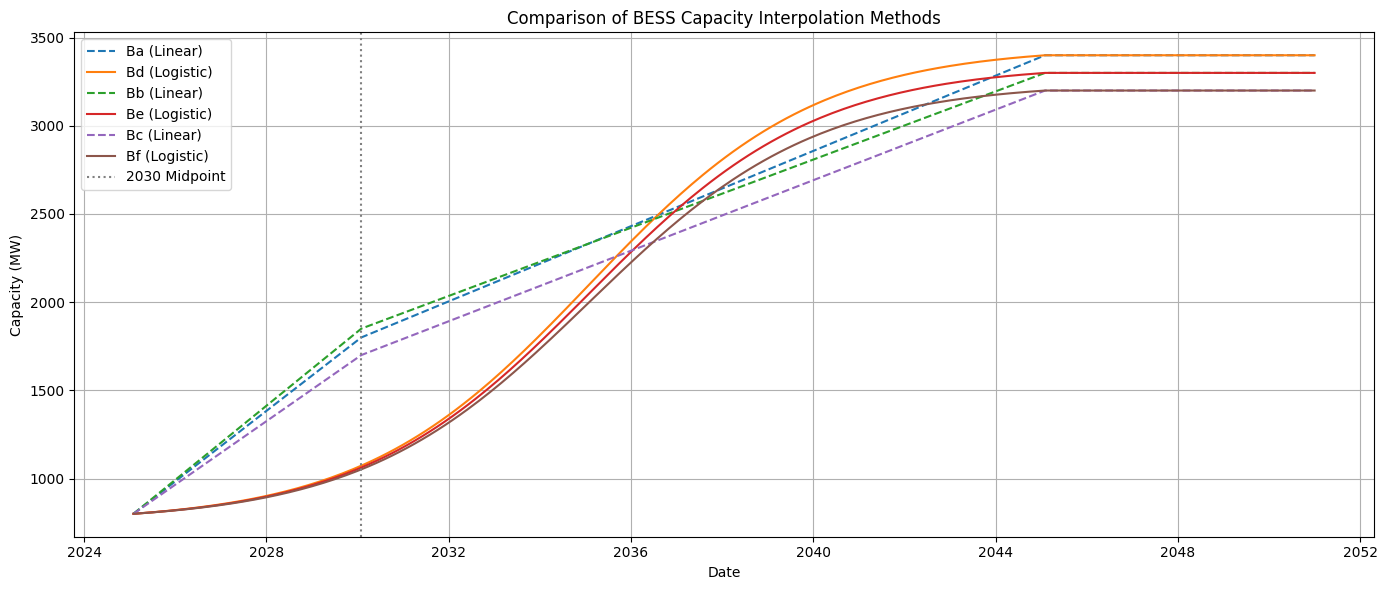

In [12]:
# Create linear future capacity Data
future_dataset = pd.read_csv("processed_data/Future dataset with BESS.csv", parse_dates=["Date"])
future_dataset.set_index("Date", inplace=True)

# Create empty capacity DataFrame
future_capacity = pd.DataFrame(index=future_dataset.index, columns=["Ba", "Bb", "Bc"])

# Set anchor points
future_capacity.iloc[0, future_capacity.columns.get_loc("Ba")] = 800
future_capacity.iloc[0, future_capacity.columns.get_loc("Bb")] = 800
future_capacity.iloc[0, future_capacity.columns.get_loc("Bc")] = 800

future_capacity.loc["2030-01-31", "Ba"] = 1800
future_capacity.loc["2030-01-31", "Bb"] = 1850
future_capacity.loc["2030-01-31", "Bc"] = 1700

future_capacity.loc["2045-01-31", "Ba"] = 3400
future_capacity.loc["2045-01-31", "Bb"] = 3300
future_capacity.loc["2045-01-31", "Bc"] = 3200

future_capacity = future_capacity.astype(float).interpolate(method="time")

# Create logistic future capacity data
logistic_capacity = pd.DataFrame(index=future_dataset.index, columns=["Bd", "Be", "Bf"])

# Anchors
anchors = {
    "start_date": "2025-01-31",
    "mid_date": "2030-01-31",
    "end_date": "2045-01-31"
}

# Generate logistic curves per scenario
logistic_range = pd.date_range(anchors["start_date"], anchors["end_date"], freq="ME")

for scenario_linear, scenario_logistic in zip(["Ba", "Bb", "Bc"], ["Bd", "Be", "Bf"]):
    y_start = future_capacity.loc[anchors["start_date"], scenario_linear]
    y_mid = future_capacity.loc[anchors["mid_date"], scenario_linear]
    y_end = future_capacity.loc[anchors["end_date"], scenario_linear]

    logistic_values = utils.smooth_logistic_growth(logistic_range, y_start, y_end, steepness = 8)
    logistic_capacity.loc[logistic_range, scenario_logistic] = logistic_values
    logistic_capacity.loc[logistic_capacity.index > anchors["end_date"], scenario_logistic] = y_end

# Plot comparison between exponential+logarithmic vs. full logistic
plt.figure(figsize=(14, 6))

for col_linear, col_logistic in zip(["Ba", "Bb", "Bc"], ["Bd", "Be", "Bf"]):
    plt.plot(future_capacity.index, future_capacity[col_linear], label=f"{col_linear} (Linear)", linestyle="--")
    plt.plot(logistic_capacity.index, logistic_capacity[col_logistic], label=f"{col_logistic} (Logistic)", linestyle="-")

plt.axvline(pd.to_datetime(anchors["mid_date"]), color='gray', linestyle=':', label="2030 Midpoint")
plt.legend()
plt.title("Comparison of BESS Capacity Interpolation Methods")
plt.xlabel("Date")
plt.ylabel("Capacity (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

future_capacity.to_csv("processed_data/Future capacity.csv")

future_data = pd.read_csv("processed_data/Future dataset with BESS.csv", parse_dates=["Date"])
future_data.set_index("Date", inplace=True)

# drop ba, bb, bc, bd, be, bf columns
future_data.drop(columns=["Ba", "Bb", "Bc", "Bd", "Be", "Bf"], inplace=True, errors='ignore')

# insert new capacity data
future_data.insert(len(future_data.columns), "Ba", future_capacity["Ba"])
future_data.insert(len(future_data.columns), "Bb", future_capacity["Bb"])
future_data.insert(len(future_data.columns), "Bc", future_capacity["Bc"])
future_data.insert(len(future_data.columns), "Bd", logistic_capacity["Bd"])
future_data.insert(len(future_data.columns), "Be", logistic_capacity["Be"])
future_data.insert(len(future_data.columns), "Bf", logistic_capacity["Bf"])

future_data.to_csv("processed_data/Future dataset with BESS.csv")

# A: Scenario Analysis

c:\Users\AlisyaMustikaa\miniconda3\Lib\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\AlisyaMustikaa\miniconda3\Lib\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\AlisyaMustikaa\miniconda3\Lib\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


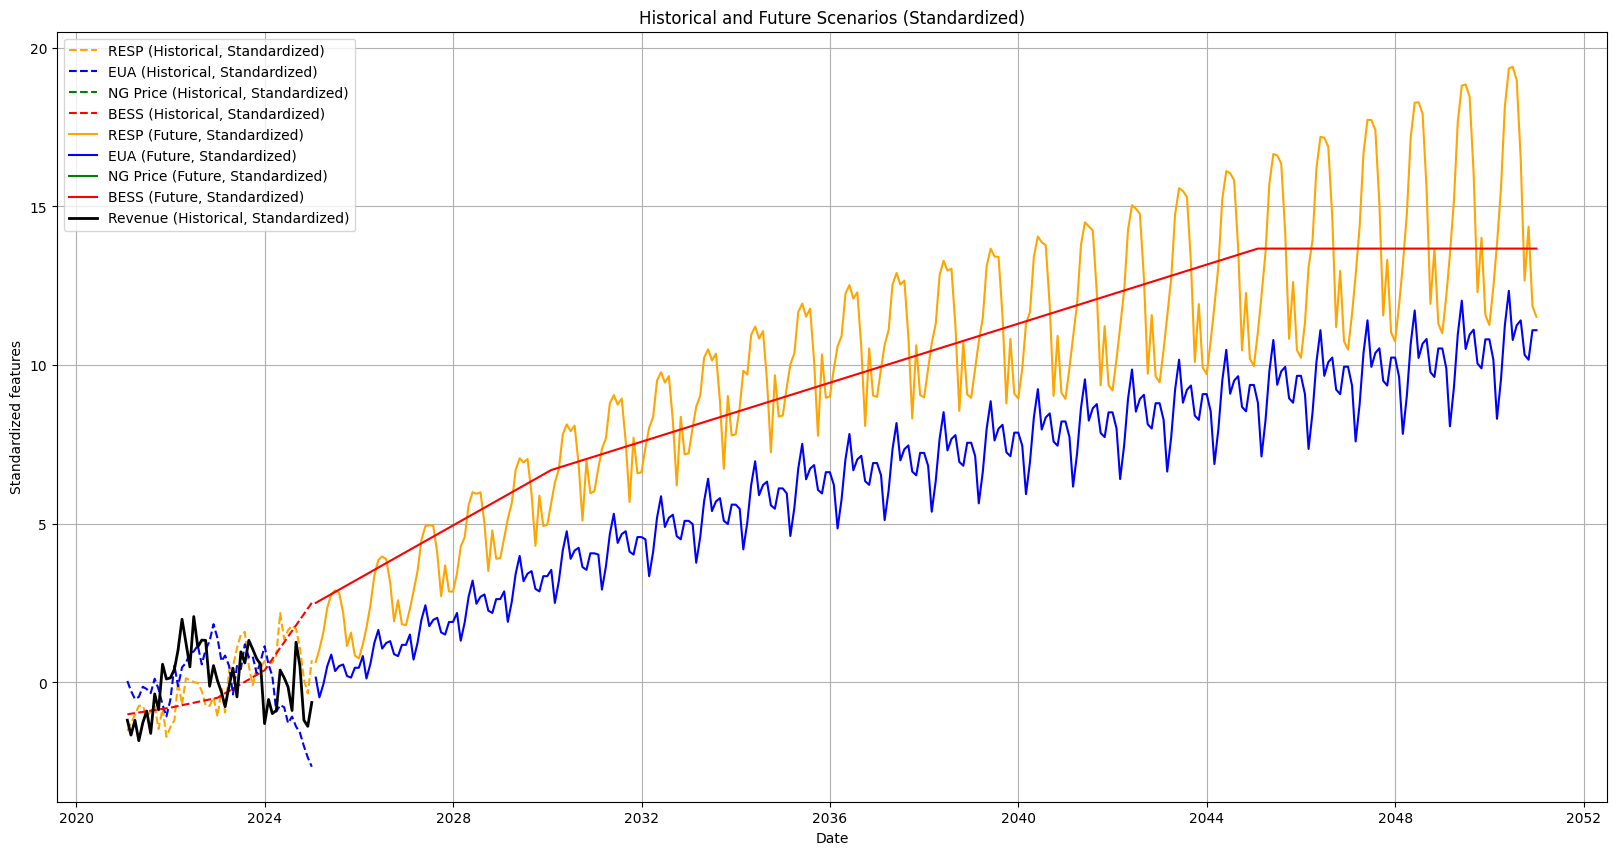

In [26]:
utils.plot_scenario("c")

# B: Model Training and Forecasting

## Intraday

In [79]:
test = pd.read_csv("processed_data/historical_data.csv", index_col=0, parse_dates=True)
print(test.head(50))

print(test["NG_Price"].isna().sum())  # Count NaNs in the column




                  BESS    EUA  NG_Price         RESP     Imbalance  \
Date                                                                 
2021-01-31   45.000000  73.00       NaN  2083.747043  14052.355917   
2021-02-28   49.090909  68.40       NaN  2345.436662  11967.316841   
2021-03-31   53.181818  64.58       NaN  2631.347361  15309.577246   
2021-04-30   57.272727  65.56       NaN  2937.190234  10925.326974   
2021-05-31   61.363636  70.30       NaN  2933.630880  14854.763637   
2021-06-30   65.454545  69.24       NaN  2578.836123  17594.166874   
2021-07-31   69.545455  67.36       NaN  2737.535303  14358.314995   
2021-08-31   73.636364  74.07       NaN  2921.437443  24165.506323   
2021-09-30   77.727273  69.20       NaN  2149.879985  19289.042689   
2021-10-31   81.818182  61.93       NaN  2842.973577  33695.241070   
2021-11-30   85.909091  56.44       NaN  1884.246252  25491.509283   
2021-12-31   90.000000  64.40       NaN  2217.839669  28396.744520   
2022-01-31   95.5833

In [92]:
import importlib
import utils  # Replace with your actual module name
importlib.reload(utils)

import statsmodels.api as sm

def train_model_gamma(feature_names=["RESP", "BESS"], outcome="Imbalance", historical_data_path="processed_data/historical_data.csv", show_summary=True):
    """
    Trains a Gamma regression model using the specified features and month dummies.
    - Parameters:
        - feature_names (list): List of feature names to include in the model.
        - outcome (str): The name of the outcome variable.
        - historical_data_path (str): Path to the historical dataset.
        - show_summary (bool): Whether to display the model summary.
    """
    historical_data = pd.read_csv(historical_data_path, parse_dates=["Date"])
    historical_data.set_index("Date", inplace=True)
    historical_data["month"] = historical_data.index.month

    # print(historical_data)

    # Create monthly dummies (drop first month to avoid multicollinearity)
    month_dummies = pd.get_dummies(historical_data["month"], prefix="Month", drop_first=True)

    # Combine features and month dummies
    X = pd.concat([historical_data[feature_names], month_dummies], axis=1)
    X = sm.add_constant(X).astype(float)

    print(X.tail())

    y = historical_data[outcome]

    X = sm.add_constant(X)

    model = sm.GLM(y, X, family=sm.families.Gamma()).fit(cov_type='HC2')

    if show_summary:
        print(model.summary())

    return model

model = train_model_gamma(outcome="Intraday", show_summary=False)
forecasts = utils.forecast_with_scenarios(model)

forecasts.to_csv("Scenarios/intraday_revenue_forecasts_combined.csv")

            const         RESP        BESS  Month_2  Month_3  Month_4  \
Date                                                                    
2024-08-31    1.0  5530.634514  647.666667      0.0      0.0      0.0   
2024-09-30    1.0  4895.881029  685.750000      0.0      0.0      0.0   
2024-10-31    1.0  3834.481660  723.833333      0.0      0.0      0.0   
2024-11-30    1.0  3350.112791  761.916667      0.0      0.0      0.0   
2024-12-31    1.0  4480.731115  800.000000      0.0      0.0      0.0   

            Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  Month_11  \
Date                                                                          
2024-08-31      0.0      0.0      0.0      1.0      0.0       0.0       0.0   
2024-09-30      0.0      0.0      0.0      0.0      1.0       0.0       0.0   
2024-10-31      0.0      0.0      0.0      0.0      0.0       1.0       0.0   
2024-11-30      0.0      0.0      0.0      0.0      0.0       0.0       1.0   
2024-12-31    

c:\Users\AlisyaMustikaa\miniconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
c:\Users\AlisyaMustikaa\miniconda3\Lib\site-packages\statsmodels\genmod\families\links.py:325: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
c:\Users\AlisyaMustikaa\miniconda3\Lib\site-packages\statsmodels\genmod\families\family.py:775: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
c:\Users\AlisyaMustikaa\miniconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:898: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
c:\Users\AlisyaMustikaa\miniconda3\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid valu

ValueError: NaN, inf or invalid value detected in weights, estimation infeasible.

## Imbalance Revenue

In [93]:
model = utils.train_model_gamma(outcome="Imbalance", show_summary=False)
forecasts = utils.forecast_with_scenarios(model)

forecasts.to_csv("Scenarios/imbalance_revenue_forecasts_combined.csv")

c:\Users\AlisyaMustikaa\miniconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


ValueError: zero-size array to reduction operation maximum which has no identity

## Day-Ahead Revenue

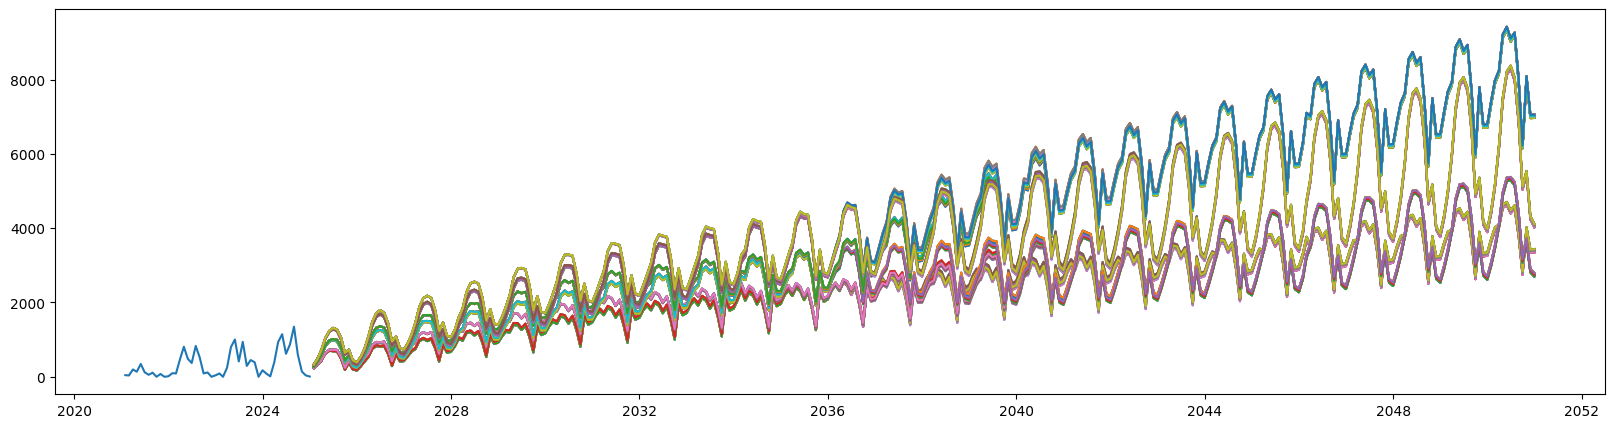

In [282]:
da_model = utils.train_model_day_ahead(show_summary=False, include_lag=False)
forecasts = utils.forecast_with_scenarios_rolling(da_model, outcome="Day-ahead Only", include_lag=False)
forecasts.to_csv("Scenarios/day_ahead_revenue_forecasts_combined.csv")

## Add the Imbalance and the Day-Ahead to get Total

In [14]:
imbalance_revenue_forecasts = pd.read_csv("imbalance_revenue_forecasts_combined.csv", parse_dates=["Date"])
imbalance_revenue_forecasts.set_index("Date", inplace=True)
day_ahead_revenue_forecasts = pd.read_csv("day_ahead_revenue_forecasts_combined.csv", parse_dates=["Date"])
day_ahead_revenue_forecasts.set_index("Date", inplace=True)

total_revenue = pd.DataFrame(index = imbalance_revenue_forecasts.index, columns = day_ahead_revenue_forecasts.columns)
total_revenue.index.name = "Date"

for i in range(len(total_revenue.columns)):
    total_revenue.iloc[:, i] = imbalance_revenue_forecasts.iloc[:, i] + day_ahead_revenue_forecasts.iloc[:, i]

# Load historical dataset
historical_data = pd.read_csv("historical_data.csv", parse_dates=["Date"])
historical_data.set_index("Date", inplace=True)

# Plot historical data
plt.figure(figsize=(20, 5))
plt.plot(historical_data.index, historical_data["Total"], label="Historical Revenue")

for column in total_revenue.columns:
    plt.plot(total_revenue.index, total_revenue[column], label=column)
plt.show()

total_revenue.to_csv("total_revenue_summed_forecasts_combined.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'imbalance_revenue_forecasts_combined.csv'

# D: Standardise Revenue Increase

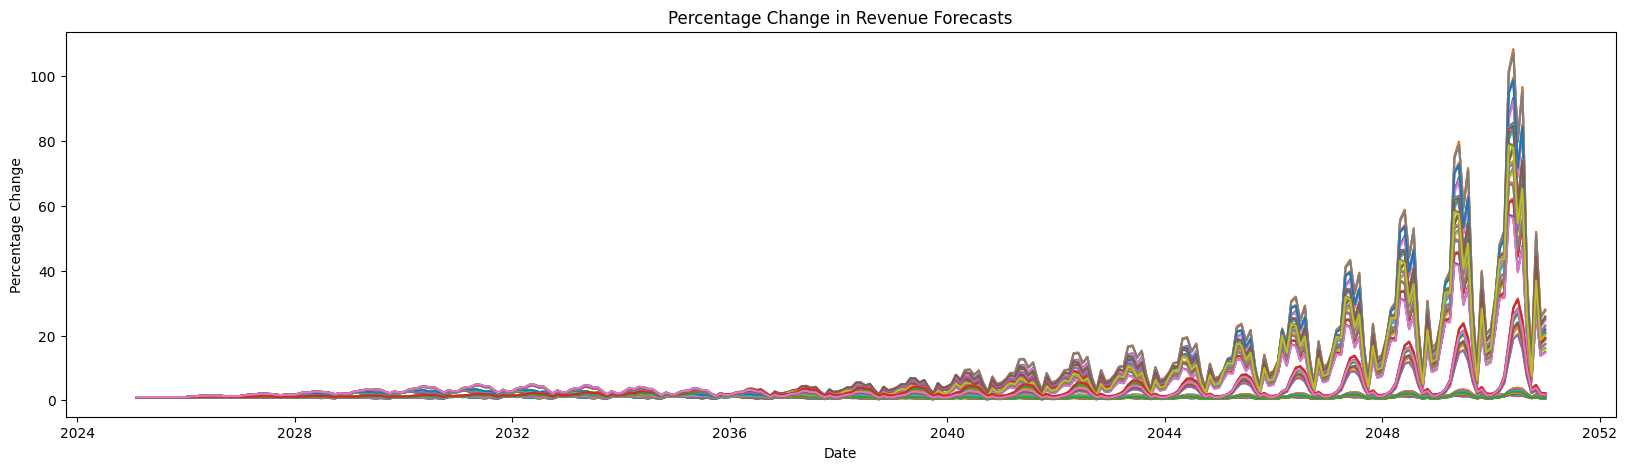

In [284]:
forecast_data = pd.read_csv("Scenarios/total_revenue_summed_forecasts_combined.csv", parse_dates=["Date"])
forecast_data.set_index("Date", inplace=True)

monthly_reference = forecast_data.groupby(forecast_data.index.month).transform("first")
forecast_data_percentage = forecast_data / monthly_reference

# plot the percentage change for each scenario
plt.figure(figsize=(20, 5))
for column in forecast_data_percentage.columns[1:]:
    plt.plot(forecast_data_percentage.index, forecast_data_percentage[column], label=column)
plt.title("Percentage Change in Revenue Forecasts")
plt.xlabel("Date")
plt.ylabel("Percentage Change")
plt.show()

forecast_data_percentage.T.to_excel("Scenarios/monthly_revenue_forecasts_percentage.xlsx", index=True, header=True)
forecast_data_percentage.to_csv("Scenarios/monthly_revenue_forecasts_percentage.csv", index=True, header=True)

# E: Resolution Conversion into Yearly

In [285]:
# Load the forecast dataset
forecast_data = pd.read_csv("Scenarios/total_revenue_summed_forecasts_combined.csv", parse_dates=["Date"])
forecast_data.set_index("Date", inplace=True)

# Resample to yearly data using sum
yearly_revenue = forecast_data.resample('YE').sum()

# Convert the Date index to the year format
yearly_revenue.index = yearly_revenue.index.year

# Select the base year (2025)
base_year = yearly_revenue.iloc[0]
base_year_values = base_year.values

# Calculate percentage change compared to 2025
percentage_change = (yearly_revenue / base_year_values) * 100

# Reset index for easier viewing
percentage_change.reset_index(inplace=True)
percentage_change.rename(columns={"index": "Year"}, inplace=True)

# Save the result to a new CSV
percentage_change.to_csv("yearly_revenue_percentage_change.csv", index=False)
percentage_change.T.to_excel("yearly_revenue_percentage_change.xlsx", index=False)

# F: Plot Yearly Forecast

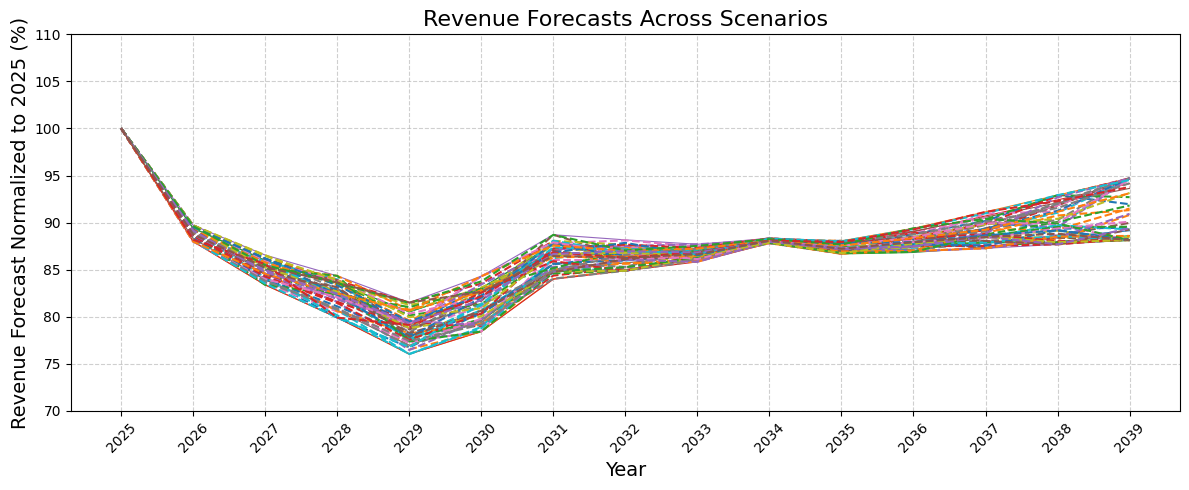

In [287]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
forecast_data = pd.read_csv("yearly_revenue_percentage_change.csv", parse_dates=["Date"])
forecast_data.set_index("Date", inplace=True)

# Filter date range
forecast_data = forecast_data.loc["2025-01-01":"2039-12-31"]

# Keep only columns where the last *non-NA* value is between 91 and 100 and max never exceeds 100
cols_to_keep = [
    col for col in forecast_data.columns
    if forecast_data[col].iloc[-1] >= 85 and forecast_data[col].iloc[-1] <= 95 and not (forecast_data[col] > 100).any()
]
forecast_data = forecast_data[cols_to_keep]

# Compute min and max across the selected scenarios at each time point
min_trend = forecast_data.min(axis=1)
max_trend = forecast_data.max(axis=1)

# Generate synthetic random trends that stay between min_trend and max_trend
num_trends = 50  # how many fake trends to add
np.random.seed(42)  # for reproducibility
random_trends = pd.DataFrame(index=forecast_data.index)

for i in range(num_trends):
    noise = np.random.normal(loc=0, scale=0.01, size=len(forecast_data))
    smooth_noise = np.cumsum(noise)
    smooth_noise = (smooth_noise - smooth_noise.min()) / (smooth_noise.max() - smooth_noise.min())  # scale to [0,1]
    scaled_trend = min_trend + smooth_noise * (max_trend - min_trend)  # stay within bounds
    random_trends[f"Random_{i+1}"] = scaled_trend

# Plot the original and random trends
plt.figure(figsize=(12, 5))
for column in forecast_data.columns:
    plt.plot(forecast_data.index, forecast_data[column], linewidth=0.8, label=column)

for column in random_trends.columns:
    plt.plot(random_trends.index, random_trends[column], linestyle="--", linewidth=1.5, label=column)

# set y axis between 70 and a 120
plt.ylim(70, 110)
plt.xticks(forecast_data.index, forecast_data.index.year, rotation=45)
plt.title("Revenue Forecasts Across Scenarios", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Revenue Forecast Normalized to 2025 (%)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



# G(A): Generate Monte Carlo Simulations

In [94]:
# Calculate std and mean of historical data
historical_data = pd.read_csv("processed_data/historical_data.csv", parse_dates=["Date"])
historical_data.set_index("Date", inplace=True)


historical_mean = historical_data["Revenue"].mean()
historical_std = historical_data["Revenue"].std()
reference_revenue = historical_data["Revenue"].iloc[-12:]
# make the length of the reference_revenue equal to forecast_months

print(f"Historical Mean: {historical_mean}")
print(f"Historical Std: {historical_std}")

# Settings
num_simulations = 50
forecast_months = (12 * 26)
np.random.seed(42)

# Trends
trends = {
    "Upward": np.linspace(0, 2 * historical_std, forecast_months),
    "Downward": np.linspace(0, -3 * historical_std, forecast_months),
    "Stable": np.zeros(forecast_months)
}

# Colors for plotting
trend_colors = {"Upward": "green", "Downward": "red", "Stable": "blue"}

# Dates
simulation_dates = pd.date_range(
    start=historical_data.index[-1],
    periods=forecast_months,
    freq='MS'
)
reference_values = np.tile(reference_revenue.values, int(np.ceil(forecast_months / len(reference_revenue))))[:forecast_months]
reference_revenue = pd.Series(reference_values, index=simulation_dates)

# Run simulations
simulations = pd.DataFrame(index=simulation_dates)
simulations_percentage_change = pd.DataFrame(index=simulation_dates)
reference = pd.DataFrame(index=simulation_dates)

for trend_label, trend_vector in trends.items():
    for i in range(num_simulations):
        noise = np.random.normal(loc=0, scale=historical_std, size=forecast_months)
        series = historical_mean + noise + trend_vector
        series = np.clip(series, 100, None)  # Ensure revenue is non-negative
        col_name = f"{trend_label}_{i+1}"
        simulations[col_name] = series


# Plot simulations
plt.figure(figsize=(20, 5))

for col in simulations.columns:
    trend_label = col.split("_")[0]  # e.g., "Upward_3" → "Upward"
    plt.plot(simulations.index, simulations[col], color=trend_colors[trend_label], linewidth=0.7)

# Plot historical revenue
plt.plot(historical_data.index, historical_data["Revenue"], label="Historical Revenue", color="black", linewidth=2)

plt.title("Simulated Revenue Forecasts by Trend Type", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True, linestyle="--", alpha=0.6)

# Custom legend for trend types
handles = [plt.Line2D([], [], color=color, label=label) for label, color in trend_colors.items()]
handles.append(plt.Line2D([], [], color="black", label="Historical Revenue", linewidth=2))
plt.legend(handles=handles, title="Trend Type", loc="upper left")
plt.tight_layout()
plt.show()

simulations.index = pd.to_datetime(simulations.index)
reference_revenue.index = pd.to_datetime(reference_revenue.index)

simulations_percentage = simulations.div(reference_revenue, axis=0)
simulations_percentage.columns = [col.split("_")[0] for col in simulations.columns]

simulations_percentage.T.to_excel("Scenarios/monthly_revenue_simulations_percentage.xlsx")
simulations_percentage.to_csv("Scenarios/monthly_revenue_simulations_percentage.csv")


KeyError: 'Revenue'

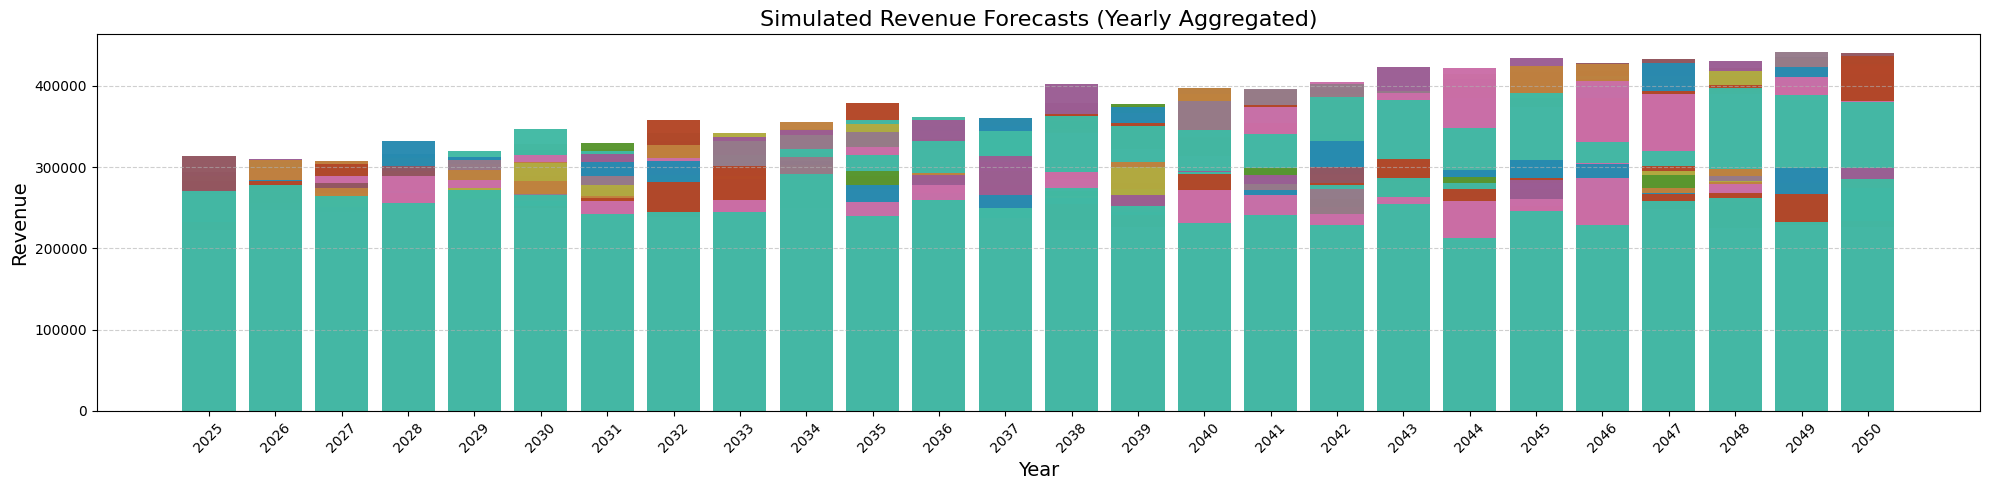

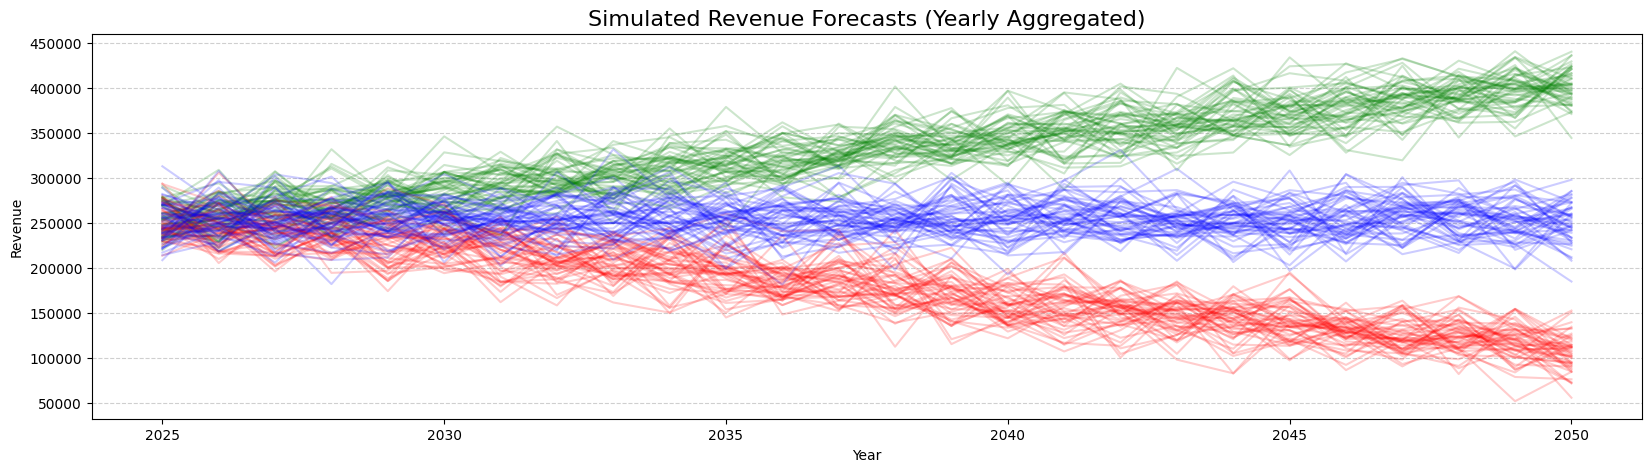

In [129]:

simulations.index = simulation_dates

# Aggregate revenues per year
simulations_yearly = simulations.resample("YE").sum()

# Convert the index to a format suitable for bar plotting (e.g., year as a string)
simulations_yearly.index = simulations_yearly.index.year

# Plot simulations as a bar plot
plt.figure(figsize=(20, 5))
for column in simulations_yearly.columns:
    for trend in trends:
        # Plot each simulation as a bar
        plt.bar(simulations_yearly.index, simulations_yearly[column], label=column, alpha=0.7)

# Add labels and title
plt.title("Simulated Revenue Forecasts (Yearly Aggregated)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Revenue", fontsize=14)
plt.xticks(simulations_yearly.index, rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# Aggregate and clean index
simulations.index = simulation_dates
simulations_yearly = simulations.resample("YE").sum()
simulations_yearly.index = simulations_yearly.index.year

# Plot
plt.figure(figsize=(20, 5))
for col in simulations_yearly.columns:
    trend_type = col.split('_')[0]
    plt.plot(simulations_yearly.index, simulations_yearly[col],
             label=col, alpha=0.2, color=trend_colors[trend_type])

plt.title("Simulated Revenue Forecasts (Yearly Aggregated)", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()





# G(B): Monte Carlo Simulation

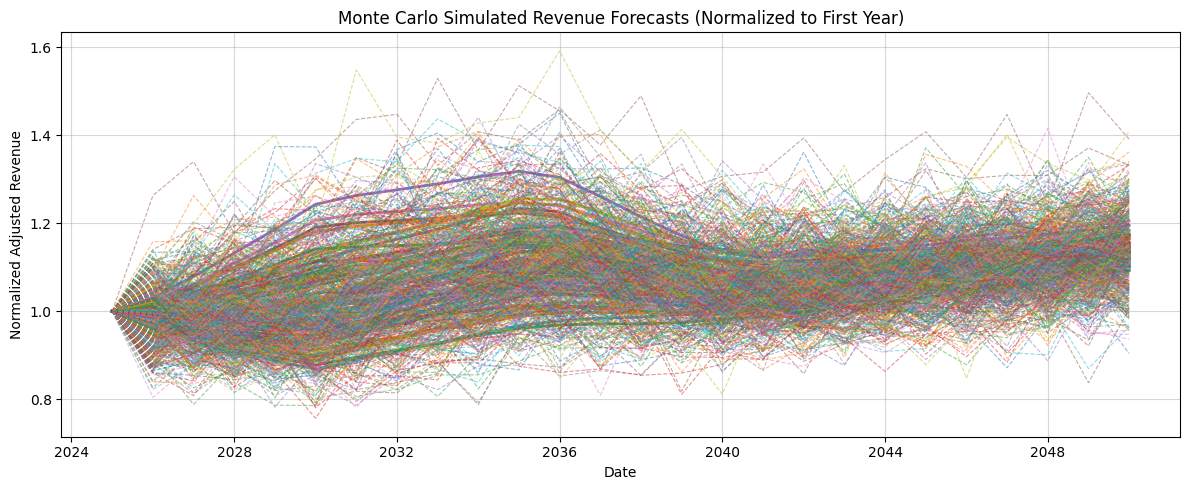

In [ ]:
# Load the adjusted revenue data
adjusted_revenue = pd.read_csv('yearly_revenue_percentage_change.csv')
adjusted_revenue['Date'] = pd.to_datetime(adjusted_revenue['Date'], format='%Y')

# Identify numerical columns
numerical_columns = adjusted_revenue.select_dtypes(include=np.number)
numerical_column_names = numerical_columns.columns

# Identify the first year (2025) as the reference year
reference_year = 2025
reference_mask = adjusted_revenue['Date'].dt.year == reference_year

# Check and get the first row of the reference year for normalization
if reference_mask.sum() == 0:
    raise ValueError("No data found for the reference year 2025.")
reference_row_index = adjusted_revenue[reference_mask].index[0]
normalization_factors = numerical_columns.loc[reference_row_index]

# Normalize the original numerical columns
numerical_columns_normalized = numerical_columns / normalization_factors

# Calculate standard deviation for each forecast line (5% of value)
std_percentage = 0.05
stds = numerical_columns_normalized * std_percentage

# Number of Monte Carlo simulations per forecast line
num_simulations = 5

# Create a DataFrame to store simulated forecasts
simulation_results = pd.DataFrame({'Date': adjusted_revenue['Date']})

# Perform Monte Carlo simulation for each forecasted line
simulated_data = {}

for column in numerical_column_names:
    means = numerical_columns_normalized[column].values
    std_devs = stds[column].values

    # Generate simulations
    simulations = np.random.normal(
        loc=np.tile(means, (num_simulations, 1)).T,
        scale=np.tile(std_devs, (num_simulations, 1)).T
    )

    # Normalize simulations to the first year's value
    base_value = simulations[reference_row_index, :]
    simulations = simulations / base_value

    # Add simulations to the dictionary
    for i in range(num_simulations):
        simulated_data[f"{column}_Sim{i+1}"] = simulations[:, i]

# Create a DataFrame from the simulated data
simulated_df = pd.DataFrame(simulated_data)

# Concatenate the simulation results with the Date column
simulation_results = pd.concat([simulation_results, simulated_df], axis=1)

# Save the simulation results to a new CSV
simulation_results.to_csv('monte_carlo_simulated_forecasts.csv', index=False)

# Plot the original lines and simulated lines
plt.figure(figsize=(12, 5))

# Plot original forecast lines
for column in numerical_column_names:
    plt.plot(adjusted_revenue['Date'], numerical_columns_normalized[column], label=f"Original {column}", linewidth=2)

# Plot Monte Carlo simulations
for column in numerical_column_names:
    for i in range(num_simulations):
        plt.plot(
            simulation_results['Date'],
            simulation_results[f"{column}_Sim{i+1}"],
            linestyle='--',
            linewidth=0.8,
            alpha=0.5
        )

plt.title("Monte Carlo Simulated Revenue Forecasts (Normalized to First Year)")
plt.xlabel("Date")
plt.ylabel("Normalized Adjusted Revenue")
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


# Z: Legacy Adjustments

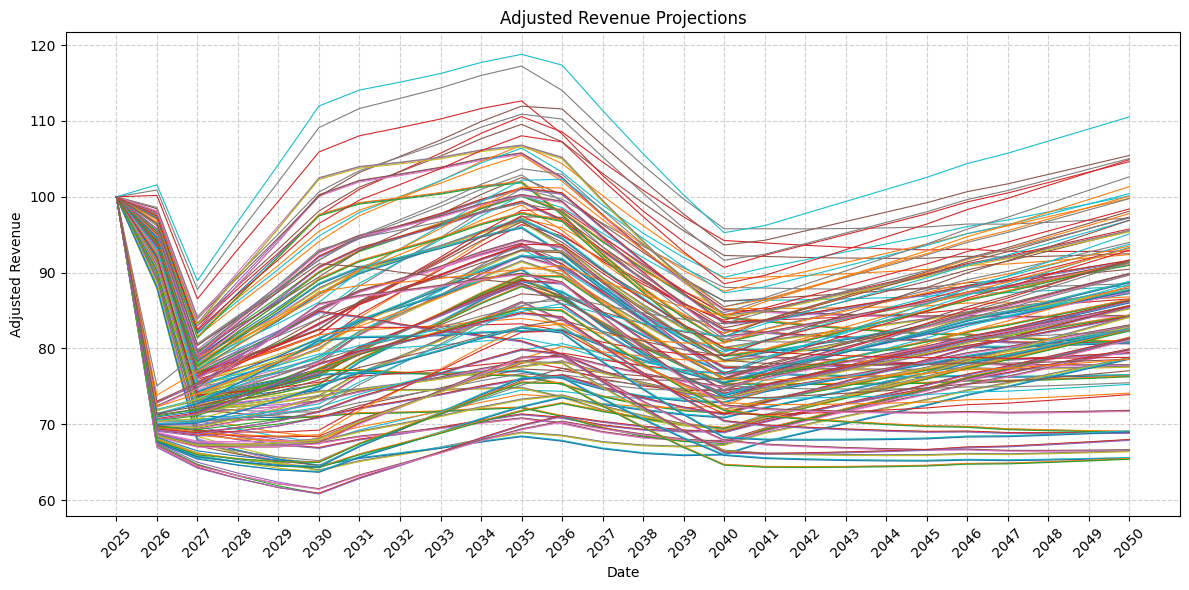

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
revenue_data = pd.read_csv('yearly_revenue_percentage_change.csv')
parameter_data = pd.read_csv('Datasets/Share Yearly.csv')
revenue_data['Date'] = pd.to_datetime(revenue_data['Date'], format='%Y')
parameter_data['Date'] = pd.to_datetime(parameter_data['Date'], format='%Y')

# Merge datasets on Date
merged_data = pd.merge(revenue_data, parameter_data, on='Date')

# Create an empty dictionary to store results
results_dict = {}

# Define mapping between revenue prefixes and parameter columns
mapping = {
    'Ra': 'A',
    'Rb': 'B',
    'Rc': 'C',
    'Rd': 'D',
    'Re': 'E',
    'Rf': 'F'
}

# Process each revenue column and apply the corresponding parameter column
for revenue_col in [col for col in revenue_data.columns if col != 'Date']:
    for prefix, param_col in mapping.items():
        # Match the revenue column name strictly
        if revenue_col.startswith(f"Revenue Forecast ({prefix}_"):
            # Combine with the corresponding parameter column only
            new_col_name = f"{revenue_col}_adjusted_{param_col}"
            adjusted_values = merged_data[revenue_col].copy()

            # Apply the new Share-based adjustment first
            for i, row in merged_data.iterrows():
                share = row[param_col]
                if share < 0.05:
                    continue  # No change
                elif 0.05 <= share < 0.2:
                    adjusted_values.iloc[i] *= 0.80
                elif share >= 0.2:
                    adjusted_values.iloc[i] *= .80

            # Apply the original adjustment
            adjusted_values *= (1 - 2 * merged_data[param_col])
            # Keep values unchanged for 2025
            adjusted_values.loc[merged_data['Date'].dt.year == 2025] = merged_data[revenue_col]

            results_dict[new_col_name] = adjusted_values
            break  # Stop checking other prefixes once matched

# Convert results_dict to a DataFrame
results = pd.DataFrame(results_dict)

# Add the Date column back to results for reference
results['Date'] = merged_data['Date']

# Identify min and max columns for each row
numerical_results = results.drop(columns=['Date'])  # Exclude Date column
results['Min Column'] = numerical_results.idxmin(axis=1)
results['Max Column'] = numerical_results.idxmax(axis=1)

# Add the actual min and max values to the results
results['Min Value'] = numerical_results.min(axis=1)
results['Max Value'] = numerical_results.max(axis=1)

# Save the results to a new CSV file
results.to_csv('adjusted_revenues_with_min_max_values.csv', index=False)

# Plot the results
plt.figure(figsize=(12, 6))
for column in numerical_results.columns:  # Plot only numerical columns
    plt.plot(results['Date'], results[column], linewidth=0.8, label=column)  # Add label for legend

# Set x-axis tick labels as they are in the results dataset
plt.xticks(results['Date'], results['Date'].dt.year, rotation=45)

plt.xlabel('Date')
plt.ylabel('Adjusted Revenue')
plt.title('Adjusted Revenue Projections')

# # Adjust legend
# plt.legend(
#     loc="upper center",          # Place legend above the plot
#     bbox_to_anchor=(0.5, -0.15), # Move legend to a position outside the plot
#     fontsize=6,                  # Adjust font size for compactness
#     ncol=6,                      # Increase the number of columns
#     frameon=False                # Remove the box around the legend
# )

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt

# Select all columns containing "Revenue Forecast"
target_columns = [col for col in results.columns if "Revenue Forecast" in col]

# Plot the results
plt.figure(figsize=(18, 5))

# Plot each target column
for column in target_columns:
    plt.plot(results['Date'], results[column], linewidth=0.8, label=column)

# Highlight year ranges with shadowed rectangles
highlight_ranges = [
    ('2025-01-01', '2030-01-01', 'lightgreen'),
    ('2030-01-01', '2035-01-01', 'yellow'),
    ('2035-01-01', '2040-01-01', 'lightpink'),
    ('2040-01-01', '2050-01-01', 'lightgray')
]
for start, end, color in highlight_ranges:
    plt.axvspan(pd.Timestamp(start), pd.Timestamp(end), color=color, alpha=0.2)

# Format the x-axis to show year only
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Labels and title
plt.xlabel('Date')
plt.ylabel('Relative Revenue Change (%)')
plt.title('Relative Revenue Projections')

#Legend to the right
plt.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),  # Position the legend to the right
    fontsize=8,
    ncol=1,
    frameon=False
)

# Grid and layout adjustments
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to avoid overlap
plt.show()
